In [4]:
import os

directory = "D:\\Code\\AI\\Model\\NumberRecognitionModel"
# directory = "/Users/danielnguyen/Repo/AI/Model/numberRecognitionModel"

new_version = input("Which version is this: ")
versions_list = sorted([int(version.replace('version', '')) for version in os.listdir(directory) if version != ".DS_Store"])

try: 
    new_version = int(new_version)
except:
    latest_version = versions_list[-1]
    new_version = latest_version + 1
else:
    new_version_folder = 'version{}'.format(int(new_version))
    new_version_path = 'version{}.hdf5'.format(int(new_version))

    path = os.path.join(directory, new_version_folder)
    if versions_list.count(new_version) == 0:
        os.makedirs(path)

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

Found 32680 images belonging to 10 classes.
Found 8164 images belonging to 10 classes.


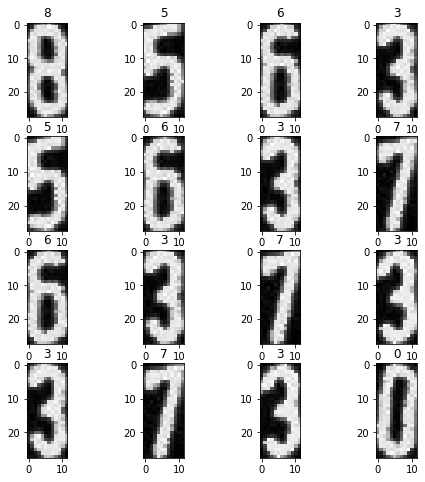

In [6]:
ds = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.2,
    fill_mode='constant',
    cval=0
)

train_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=128,
    subset='training',
    color_mode='grayscale',
    class_mode='sparse'
)

validation_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=128,
    subset='validation',
    color_mode='grayscale',
    class_mode='sparse'
)

input_shape = train_ds[0][0][0].shape

plt.rcParams["figure.figsize"] = (8,8)
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(validation_ds[0][0][i + j], cmap='gray')
        axs[i, j].set_title(int(validation_ds[0][1][i + j]))

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((28,12,1)),
    tf.keras.layers.Conv2D(8, (3,3), activation='elu',
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='elu', 
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='elu', 
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
            loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.losses.SparseCategoricalCrossentropy(),
                    'accuracy'])

In [8]:
%%writefile {path}/model.py
import tensorflow as tf

def create_model() :
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((28,12,1)),
        tf.keras.layers.Conv2D(8, (3,3), activation='elu',
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation='elu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='elu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                loss='sparse_categorical_crossentropy',
                metrics=[tf.keras.losses.SparseCategoricalCrossentropy(),
                        'accuracy'])

    return model

Overwriting D:\Code\AI\Model\NumberRecognitionModel\version8/model.py


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 12, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 12, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 6, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 6, 16)         1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 6, 16)         64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 3, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 3, 32)          4

In [10]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('val_accuracy') >= 0.999 and logs.get('accuracy') >= 0.999) :
            print('\nReached 99% accuracy so stopping training')
            self.model.stop_training = True



save_path = os.path.join(path, new_version_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True)

In [11]:
callback = stopCallback()

history = model.fit(train_ds, 
                    epochs=200, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=validation_ds)

Epoch 1/200
256/256 [==============================] - 16s 62ms/step - loss: 0.1986 - sparse_categorical_crossentropy: 0.1884 - accuracy: 0.9557 - val_loss: 1.0877 - val_sparse_categorical_crossentropy: 1.0784 - val_accuracy: 0.6469
Epoch 2/200
256/256 [==============================] - 15s 60ms/step - loss: 0.0266 - sparse_categorical_crossentropy: 0.0168 - accuracy: 0.9967 - val_loss: 0.0469 - val_sparse_categorical_crossentropy: 0.0371 - val_accuracy: 0.9953
Epoch 3/200
256/256 [==============================] - 15s 58ms/step - loss: 0.0210 - sparse_categorical_crossentropy: 0.0112 - accuracy: 0.9978 - val_loss: 0.0185 - val_sparse_categorical_crossentropy: 0.0087 - val_accuracy: 0.9983
Epoch 4/200
256/256 [==============================] - 15s 59ms/step - loss: 0.0186 - sparse_categorical_crossentropy: 0.0088 - accuracy: 0.9982 - val_loss: 0.0166 - val_sparse_categorical_crossentropy: 0.0068 - val_accuracy: 0.9985
Epoch 5/200
256/256 [==============================] - 15s 58ms/step

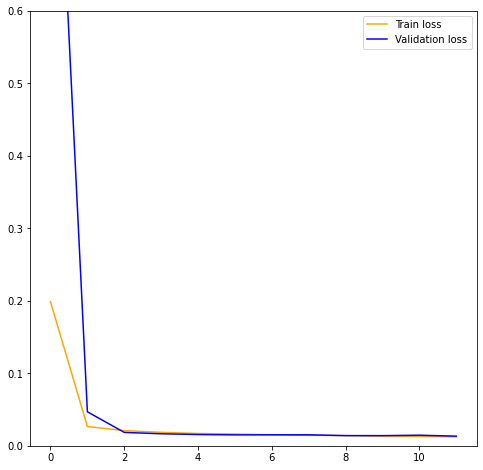

In [12]:
plt.plot(history.history['loss'], color='orange', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.ylim((0, 0.6))
plt.legend()
plt.show()

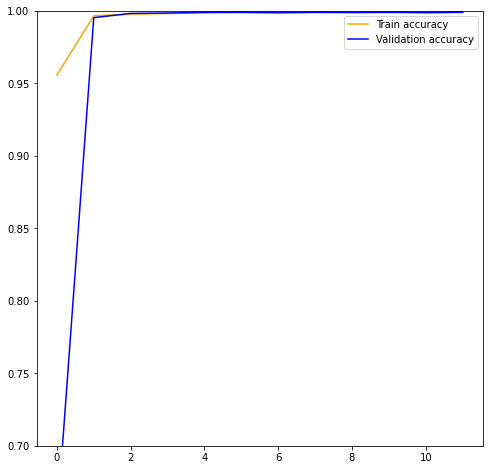

In [13]:
plt.plot(history.history['accuracy'], color='orange', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation accuracy')
plt.ylim((0.7, 1))
plt.legend()
plt.show()

7


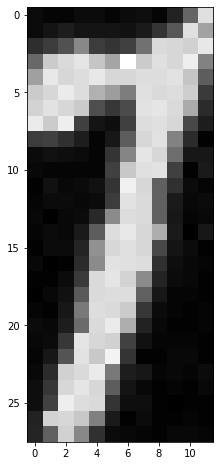

In [17]:
test_img = validation_ds[1][0][100]

import numpy as np

plt.imshow(test_img, cmap='gray')

print(np.argmax(model.predict(np.expand_dims(test_img, 0))))